# Multivariate time series forecasting with LSTM
* Source: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

## 1. Air pollution forecasting

In [10]:
import pandas as pd
from datetime import datetime

def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

file_path='../data/airPollution.csv'
dataset = pd.read_csv(file_path, parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)

In [11]:
dataset.drop('No', axis =1, inplace=True)

In [12]:
dataset.head(4)

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0


In [13]:
dataset.columns=['pollution', 'dew','temp','press','wnd_dir','wnd_spd','snow','rain']
dataset.index.name='date'

# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)

# drop first 24 hours
dataset=dataset[24:]

print(dataset.head(4))

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0


In [15]:
dataset.to_csv('../data/pollution.csv')

Now we can quickly see what we have.

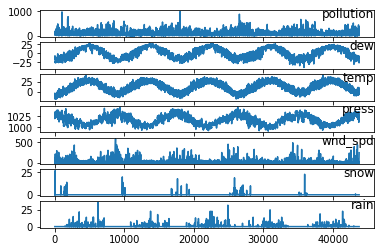

In [18]:
from matplotlib import pyplot as plt
%matplotlib inline

dataset=pd.read_csv('../data/pollution.csv', header=0,index_col=0)
values=dataset.values

# specificy columns to plot
groups=[0,1,2,3,5,6,7]
i=1
#plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i+=1
plt.show()

## 2. LSTM data preparation
The first step is to prepare the pollution dataset for the LSTM. This involves framing the dataset as a supervised learning problem and normalizing the input variables. We will frame the supervised learning problem as predicting the pollution at the current hour(t) given the pollution measurement and weather conditions at the prior time step. 

This formation is straightforward and just for this demonstration. 

In [26]:
# source: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars=1 if type(data) is list else data.shape[1]
    df=pd.DataFrame(data)
    cols,names=list(),list()
    
    # input sequence (t-n,... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... , t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i ==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg=pd.concat(cols, axis=1)
    agg.columns=names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [27]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

In [28]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [29]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


More idea sto improve and explore:
* One-hot encoding wind speed.
* Making all series stationary with differencing and seasonal adjustment.
* Providing more than 1 hour of input time steps.

## 3. Define and fit the model

In [75]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


In [76]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [77]:
model=Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history=model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 2s - loss: 0.0555 - val_loss: 0.0560
Epoch 2/50
 - 1s - loss: 0.0383 - val_loss: 0.0579
Epoch 3/50
 - 1s - loss: 0.0233 - val_loss: 0.0505
Epoch 4/50
 - 1s - loss: 0.0166 - val_loss: 0.0393
Epoch 5/50
 - 1s - loss: 0.0155 - val_loss: 0.0279
Epoch 6/50
 - 1s - loss: 0.0149 - val_loss: 0.0217
Epoch 7/50
 - 1s - loss: 0.0147 - val_loss: 0.0185
Epoch 8/50
 - 1s - loss: 0.0147 - val_loss: 0.0171
Epoch 9/50
 - 1s - loss: 0.0147 - val_loss: 0.0157
Epoch 10/50
 - 1s - loss: 0.0144 - val_loss: 0.0148
Epoch 11/50
 - 1s - loss: 0.0146 - val_loss: 0.0145
Epoch 12/50
 - 1s - loss: 0.0145 - val_loss: 0.0144
Epoch 13/50
 - 1s - loss: 0.0146 - val_loss: 0.0142
Epoch 14/50
 - 1s - loss: 0.0143 - val_loss: 0.0142
Epoch 15/50
 - 1s - loss: 0.0146 - val_loss: 0.0141
Epoch 16/50
 - 1s - loss: 0.0144 - val_loss: 0.0141
Epoch 17/50
 - 1s - loss: 0.0145 - val_loss: 0.0141
Epoch 18/50
 - 1s - loss: 0.0144 - val_loss: 0.0140
Epoch 19/50
 - 1s - loss

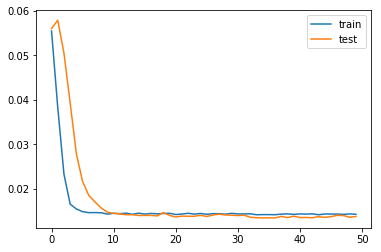

In [78]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [79]:
from numpy import concatenate
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.646
